# Naive Bayes classifier for text genre detection.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### i unpacked data to my Google drive and then google.colab got access to these text data 

In [0]:
import os
os.chdir("/content/gdrive/My Drive/AI/NLP")

###  I used Natural Language Toolkit to work with language data. In particular, I used "stopwords" to filter out useless words, "lemmatizer" to reduce the inflected words properly ensuring that the root word belongs to the language and "re" module which provides regular expression matching operations" extract email, extract less than 1-2 char, Leaving English words only.

In [3]:
import pandas as pd
import numpy as np
import math
from collections import Counter

import re
import nltk

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

lemmatizer = nltk.WordNetLemmatizer()

from nltk.corpus import stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

stopWords = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))

from sklearn.model_selection import train_test_split

# Text preprocessing
def preprocess(text):
    
  # extract email, extract less than 1-2 char, Leaving English words only
  text = re.sub(
       r"[a-z0-9]+[\.'_+\-]*[a-z0-9]+@[a-z0-9]+[\.'\-]*[a-z0-9]+|\\n\||[^A-Za-z]\b\w{1,2}\b|[^A-Za-z]",
       " ", text)
    
  # multiple spaces are replaced by single space
  text = re.sub('(\s+)',' ',text)
  text = text.lower() 
  nltk_tokens = nltk.word_tokenize(text)
  
  # lematizing
  line = ' '.join([lemmatizer.lemmatize(w) for w in nltk_tokens 
                                                   if w not in stopWords])
                 
  return line


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### loading preprocessed text data in a pandas dataframe 

In [4]:
path = 'data/'
genres = os.listdir(path)
print(genres)

list_df = []

for genre in genres:
  print(genre) 
  dir = os.listdir(path + genre)
  for file in dir:
      filename = path + genre + "/" +  file
      try:
        text = ''.join(open(filename,"r", encoding='utf8').read())
      except UnicodeDecodeError:
        text = ''.join(open(filename,"r", encoding='latin1').read())
      text = preprocess(text)
      list_df.append([genre, text])  
      
      
df = pd.DataFrame(list_df,columns=['genre', 'text'])

['DETECT', 'ADVENTUR', 'FANTAST', 'TALES', 'JOURNAL', 'CHILD']
DETECT
ADVENTUR
FANTAST
TALES
JOURNAL
CHILD


### splitting data frame for training and testing samples

In [41]:
Genre_Train, Genre_Test = train_test_split(df, test_size=0.20)
print('Train Shape:', Genre_Train.shape)
print('Test Shape:', Genre_Test.shape)

Train Shape: (134, 2)
Test Shape: (34, 2)


### part of preprocessed training dataset:

In [42]:
Genre_Train.iloc[0:10]

,genre,text
98,FANTAST,william gibson neuromancer dedication deb poss...
53,ADVENTUR,david eleanor porter digitized cardinalis pres...
159,CHILD,jpg johanna spyri heidi remember dream real ye...
11,DETECT,harry kemelman wednesday rabbi got wet chapter...
12,DETECT,basil copper solar pons final case basil coppe...
74,ADVENTUR,tarzan jewel opar edgar rice burroughs content...
33,DETECT,richard storry cryptic line prologuei paid sic...
127,TALES,lewis carroll hunting snark agony fit lewis ca...
158,CHILD,woodland tale ernest thompson seton jpg drawin...
4,DETECT,obi doyle hound baskervilles txt chapter sherl...


###constructing of Bag of Words  for each genre to train Naïve Bayes Model 

In [0]:
def BoW():
  model = {}
  
  for g in range(len(genres)):
      genre = genres[g]
      df_genre = Genre_Train[Genre_Train.genre == genre].reset_index()
      counter = Counter()
      for x in range(len(df_genre)):
          review = df_genre['text'][x].split()
          s = [word for word in review]
          counter.update(s)
      model[genre] = dict(counter)
  return model    

### calculating probability to predict genre for Tokenized Test Example

 [count(word|genre)+1 ] / [ count(genres) + |V| + 1 ] 

|V| -  vocabulary  of each genre

I used Laplace smoothing to avoid zero probability of a test word that NEVER EVER APPEARED IN THE TRAINING DATASET.
        
        i will precompute all of them & use them during test time to speed up predictions. 
        

In [0]:
# taking log To prevent underflow
def get_prob_model():
  vocabulary_genre = {}
  for key in model.keys():
    print(key)
    V = sum(model[key].values())
    vocabulary_genre[key] = V
   
    for word, vocabulary in model[key].items():
        model[key][word] = math.log((vocabulary + 1)/float(V + 1)) 
  
  # probability for missing words
  for genre, _vocabulary in vocabulary_genre.items():
     vocabulary_genre[genre] = math.log(1/float(_vocabulary + 1))
      
  return vocabulary_genre

In [0]:
# now get likelihood of the token words  
def get_probability(genre, text):
  probability_genre = 0
  for word in text.split():
    try:
      prob = model[genre][word] 
    except:
      prob = vocabulary_genre[genre]
    probability_genre += prob #log product +
    
  return probability_genre      

In [0]:
def get_predictions():
  predictions = []
  for row in Genre_Test.itertuples():
    post_prob = np.empty(len(genres))
    for index, genre in enumerate(genres):
        #get the posterior probability of every example 
        post_prob[index] = get_probability(genre, row.text)
    #pick the max value up
    predictions.append(genres[np.argmax(post_prob)])
  return predictions

In [43]:
model = BoW()
vocabulary_genre = get_prob_model()
predictions = get_predictions()


DETECT
ADVENTUR
FANTAST
TALES
JOURNAL
CHILD


In [0]:
test_labels = Genre_Test['genre'].values

In [0]:
#check how many predcitions actually match original test labels
test_acc = np.sum(predictions == test_labels)/float(test_labels.shape[0])

In [46]:
print ("Test Set Examples: ", test_labels.shape[0]) 
print ("Test Set Accuracy: ", test_acc*100, "%") 

Test Set Examples:  34
Test Set Accuracy:  70.58823529411765 %


### Overall, how often is the classifier correct? about 7 times from 10

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix


In [47]:

print('Classification Report:')
print(classification_report(test_labels, predictions))

Classification Report:
              precision    recall  f1-score   support

    ADVENTUR       1.00      0.89      0.94         9
       CHILD       1.00      0.40      0.57        10
      DETECT       1.00      0.80      0.89         5
     FANTAST       0.62      0.83      0.71         6
     JOURNAL       0.50      0.50      0.50         2
       TALES       0.25      1.00      0.40         2

   micro avg       0.71      0.71      0.71        34
   macro avg       0.73      0.74      0.67        34
weighted avg       0.86      0.71      0.73        34



The classifier made a total of 34 predictions. Classification Report showed
the best result of precision     **ADVETUR**,  **DETECT** and **CHILD**. But **CHILD** had low RECALL.
RECALL for  **TALES** is 1 - it means the classifier could find all genre instances in the data set. **ADVENTUR       ** was right finded on 89%. 
But PRECISIONS revealed that **JOURNAL**, **FANTAST** and **TALES**  got redundant labeled texts. As result **JOURNAL** had low score. Lower result for **TALES**.
**JOURNAL** and  **TALES** had less number of actual occurrences in the test data set.
And **JOURNAL** had much less samples in the distribution than other genres.

It is difficult to compare two models with low precision and high recall or vice versa. So to make them comparable, we use F-Score. F-score helps to measure Recall and Precision at the same time. It uses Harmonic Mean in place of Arithmetic Mean by punishing the extreme values more.

The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0.
Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. 


In [0]:
import itertools
%matplotlib inline
from matplotlib import pyplot as plt
	
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')    

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [49]:
cnf_matrix = confusion_matrix(test_labels, predictions, labels = genres)
print(cnf_matrix)

[[4 0 1 0 0 0]
 [0 8 0 1 0 0]
 [0 0 5 0 1 0]
 [0 0 0 2 0 0]
 [0 0 1 0 1 0]
 [0 0 1 5 0 4]]


Confusion matrix, without normalization


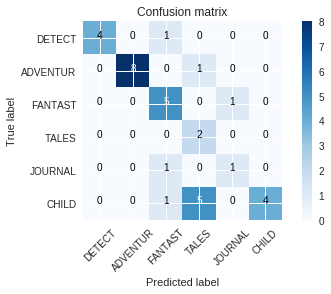

In [50]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = genres, normalize=False,  title='Confusion matrix')

How i mentioned above **JOURNAL** got redundant labeled texts. Confusion matrix showed that **JOURNAL** had the same value prediction as **FANTAST**.

Evidently, even this very simple classifier can successfully separate **ADVENTUR** text from others, but it gets confused between **CHILD** text and **TALES** text . 
 
I tried to enhance the result to join of the genres  **CHILD** -  **TALES**  and **JOURNAL**-**FANTAST**.

In [0]:
df1 = df.copy(deep=True)

In [0]:
df1.groupby('genre')['genre'].count()

genre
ADVENTUR    39
CHILD       32
DETECT      39
FANTAST     30
JOURNAL      8
TALES       20
Name: genre, dtype: int64

In [0]:
df1['genre'] = np.where(df1.genre == 'CHILD', 'TALES', df1.genre)
df1['genre'] = np.where(df1.genre == 'JOURNAL', 'FANTAST', df1.genre)

In [0]:
df1.groupby('genre')['genre'].count()

genre
ADVENTUR    39
DETECT      39
FANTAST     38
TALES       52
Name: genre, dtype: int64

In [0]:
Genre_Train, Genre_Test = train_test_split(df1, test_size=0.20)
print('Train Shape:', Genre_Train.shape)
print('Test Shape:', Genre_Test.shape)

Train Shape: (134, 2)
Test Shape: (34, 2)


In [0]:
genres = df1['genre'].unique().tolist()

In [0]:
genres

['DETECT', 'ADVENTUR', 'FANTAST', 'TALES']

In [0]:

model = BoW()
vocabulary_genre = get_prob_model()
predictions = get_predictions()


DETECT
ADVENTUR
FANTAST
TALES


In [0]:
test_labels = Genre_Test['genre'].values

In [0]:
#check how many predcitions actually match original test labels
test_acc = np.sum(predictions == test_labels)/float(test_labels.shape[0])

In [0]:
print ("Test Set Examples: ", test_labels.shape[0]) 
print ("Test Set Accuracy: ", test_acc*100, "%") 

Test Set Examples:  34
Test Set Accuracy:  94.11764705882352 %


In [0]:
print('Classification Report:')
print(classification_report(test_labels, predictions))

Classification Report:
              precision    recall  f1-score   support

    ADVENTUR       0.91      1.00      0.95        10
      DETECT       1.00      1.00      1.00         7
     FANTAST       0.80      0.80      0.80         5
       TALES       1.00      0.92      0.96        12

   micro avg       0.94      0.94      0.94        34
   macro avg       0.93      0.93      0.93        34
weighted avg       0.94      0.94      0.94        34



In [0]:
cnf_matrix = confusion_matrix(test_labels, predictions, labels = genres)
print(cnf_matrix)

[[ 7  0  0  0]
 [ 0 10  0  0]
 [ 0  1  4  0]
 [ 0  0  1 11]]


Confusion matrix, without normalization


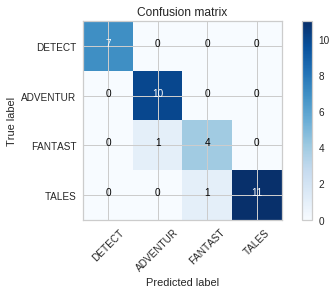

In [0]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = genres, normalize=False,
                      title='Confusion matrix')

### Obviously, the model is enhanced. It is well to join together  CHILD and TALES but JOURNAL and FANTAST are not the same domain of information. In this case, there have to get more appropriate data to make much more accurate predictive model for the Journal genre.


### Just dropping certain genre

In [0]:
df2 = df.copy(deep=True)

In [0]:
df2['genre'] = np.where(df2.genre == 'CHILD', 'TALES', df2.genre)

In [0]:
df2 = df2[df2.genre != 'JOURNAL']



In [55]:
genres = df2['genre'].unique().tolist()
genres

['DETECT', 'ADVENTUR', 'FANTAST', 'TALES']

In [78]:
Genre_Train, Genre_Test = train_test_split(df2, test_size=0.20)
print('Train Shape:', Genre_Train.shape)
print('Test Shape:', Genre_Test.shape)

Train Shape: (128, 2)
Test Shape: (32, 2)


In [79]:
model = BoW()
vocabulary_genre = get_prob_model()
predictions = get_predictions()


DETECT
ADVENTUR
FANTAST
TALES


In [0]:
test_labels = Genre_Test['genre'].values

In [0]:
#check how many predcitions actually match original test labels
test_acc = np.sum(predictions == test_labels)/float(test_labels.shape[0])

In [82]:
print ("Test Set Examples: ", test_labels.shape[0]) 
print ("Test Set Accuracy: ", test_acc*100, "%") 

Test Set Examples:  32
Test Set Accuracy:  71.875 %


In [83]:
print('Classification Report:')
print(classification_report(test_labels, predictions))

Classification Report:
              precision    recall  f1-score   support

    ADVENTUR       0.86      0.67      0.75         9
      DETECT       0.57      0.80      0.67         5
     FANTAST       0.67      0.75      0.71         8
       TALES       0.78      0.70      0.74        10

   micro avg       0.72      0.72      0.72        32
   macro avg       0.72      0.73      0.71        32
weighted avg       0.74      0.72      0.72        32



In [84]:
cnf_matrix = confusion_matrix(test_labels, predictions, labels = genres)
print(cnf_matrix)

[[4 0 1 0]
 [1 6 0 2]
 [1 1 6 0]
 [1 0 2 7]]


Confusion matrix, without normalization


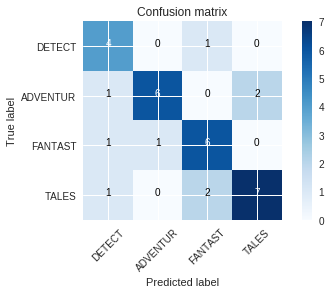

In [85]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = genres, normalize=False,
                      title='Confusion matrix')

In [86]:
df.groupby('genre')['genre'].count()

genre
ADVENTUR    39
CHILD       32
DETECT      39
FANTAST     30
JOURNAL      8
TALES       20
Name: genre, dtype: int64

Doing random spliting check result showed diffrent score every time and diffrent value of metriks. I think it might indicate structural weaknesses, for more appropriate result we could try to use more balanced number of books.
